In [1]:
import sys
sys.path.append("../../underactuated")

In [2]:
from time import sleep

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, clear_output, display
from matplotlib import cm
from pydrake.all import (DiagramBuilder, DiscreteAlgebraicRiccatiEquation,
                         DynamicProgrammingOptions, FittedValueIteration,
                         InputPortIndex, LeafSystem, LinearSystem,
                         LogVectorOutput, MathematicalProgram,
                         MeshcatVisualizerCpp, MultilayerPerceptron,
                         PerceptronActivationType, PeriodicBoundaryCondition,
                         Polynomial, RandomGenerator, Rgba, RigidTransform,
                         RotationMatrix, SceneGraph, Simulator, Solve,
                         StartMeshcat, SymbolicVectorSystem, Variable,
                         Variables, WrapToSystem, ZeroOrderHold)
from pydrake.examples.acrobot import AcrobotGeometry, AcrobotPlant
from pydrake.examples.pendulum import (PendulumGeometry, PendulumParams,
                                       PendulumPlant)

from underactuated.jupyter import AdvanceToAndVisualize, running_as_notebook
from underactuated.meshcat_cpp_utils import interact, plot_surface
from underactuated.optimizers import Adam
from underactuated.pendulum import PendulumVisualizer

INFO:drake:Meshcat listening for connections at http://localhost:7002
INFO:drake:Computing transition and cost matrices.
INFO:drake:Done computing transition and cost matrices.
INFO:drake:Running value iteration.
INFO:drake:Value iteration converged to requested tolerance.


Simulating...
simulating...  done.
generating animation...


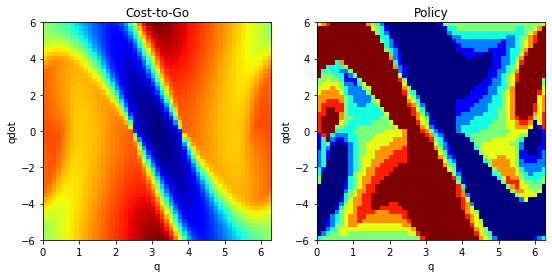

None

In [3]:
meshcat = StartMeshcat()

def pendulum_swingup_example(min_time=True, animate=True):
    plant = PendulumPlant()
    simulator = Simulator(plant)
    options = DynamicProgrammingOptions()

    qbins = np.linspace(0., 2. * np.pi, 51)
    qdotbins = np.linspace(-6., 6., 51)
    state_grid = [set(qbins), set(qdotbins)]
    options.periodic_boundary_conditions = [
        PeriodicBoundaryCondition(0, 0., 2. * np.pi),
    ]
    options.discount_factor = .999
    input_limit = 3.
    input_grid = [set(np.linspace(-input_limit, input_limit, 9))]
    timestep = 0.01

    [Q, Qdot] = np.meshgrid(qbins, qdotbins)

    meshcat.Delete()
    meshcat.SetProperty("/Background", "visible", False)

    def draw(iteration, mesh, cost_to_go, policy):
        # Don't draw every frame.
        if iteration % 20 != 0:
            return

        plot_surface(meshcat,
                     'Cost-to-go',
                     Q,
                     Qdot,
                     np.reshape(cost_to_go, Q.shape),
                     wireframe=True)
        plot_surface(meshcat,
                     'Policy',
                     Q,
                     Qdot,
                     np.reshape(policy, Q.shape),
                     rgba=Rgba(.3, .3, .5))

        # Slow down the algorithm so we can visualize the convergence.
        sleep(0.1)

    def simulate(policy):
        # Animate the resulting policy.
        builder = DiagramBuilder()
        pendulum = builder.AddSystem(PendulumPlant())

        wrap = builder.AddSystem(WrapToSystem(2))
        wrap.set_interval(0, 0, 2*np.pi)
        builder.Connect(pendulum.get_output_port(0), wrap.get_input_port(0))
        vi_policy = builder.AddSystem(policy)
        builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
        builder.Connect(vi_policy.get_output_port(0),
                        pendulum.get_input_port(0))

        visualizer = builder.AddSystem(
            PendulumVisualizer(show=False))
        builder.Connect(pendulum.get_output_port(0),
                        visualizer.get_input_port(0))

        diagram = builder.Build()
        simulator = Simulator(diagram)
        simulator.get_mutable_context().SetContinuousState([0.1, 0.0])

        AdvanceToAndVisualize(simulator, visualizer, 8.)

    if running_as_notebook:
        options.visualization_callback = draw

    def min_time_cost(context):
        x = context.get_continuous_state_vector().CopyToVector()
        x[0] = x[0] - np.pi
        if x.dot(x) < .05:
            return 0.
        return 1.

    def quadratic_regulator_cost(context):
        x = context.get_continuous_state_vector().CopyToVector()
        x[0] = x[0] - np.pi
        u = plant.EvalVectorInput(context, 0).CopyToVector()
        return 2 * x.dot(x) + u.dot(u)

    if min_time:
        cost_function = min_time_cost
        options.convergence_tol = 0.001
    else:
        cost_function = quadratic_regulator_cost
        options.convergence_tol = 0.1

    policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                              state_grid, input_grid, timestep,
                                              options)

    J = np.reshape(cost_to_go, Q.shape)
    np.save("J", J)

    plot_surface(meshcat, 'Cost-to-go', Q, Qdot, J, wireframe=True)

    if animate:
        print('Simulating...')
        simulate(policy)

    fig = plt.figure(figsize=(9, 4))
    ax1, ax2 = fig.subplots(1, 2)
    ax1.set_xlabel("q")
    ax1.set_ylabel("qdot")
    ax1.set_title("Cost-to-Go")
    ax2.set_xlabel("q")
    ax2.set_ylabel("qdot")
    ax2.set_title("Policy")
    ax1.imshow(J,
               cmap=cm.jet, aspect='auto',
               extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]))
    ax1.invert_yaxis()
    Pi = np.reshape(policy.get_output_values(), Q.shape)
    ax2.imshow(Pi,
               cmap=cm.jet, aspect='auto',
               extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]))
    ax2.invert_yaxis()
    display(plt.show())


pendulum_swingup_example(min_time=False, animate=True)